In [139]:
import pandas as pd
import json
import copy, yaml
import matplotlib.pyplot as plt
from flowcept import Flowcept

In [210]:
docs = Flowcept.read_buffer_file()
df = Flowcept.read_buffer_file(return_df=True, normalize_df=True)
len(docs)

33

In [ ]:
# df

# 1. Search Workflow only

For rows with type='task' and status='FINISHED' , display the CPU utilization (difference between end-start), used hyperparameter and generated loss:

In [168]:
# Get start CPU% per task_id from any row that has it (e.g., the RUNNING row)
starts = (
    df.dropna(subset=["telemetry_at_start.cpu.percent_all"])
      .groupby("task_id")["telemetry_at_start.cpu.percent_all"]
      .first()
)

# FINISHED tasks with CPU utilization = end - start
result = (
    df.loc[
        (df["type"].eq("task")) & (df["status"].eq("FINISHED") & (df['activity_id'] == 'model_train')),
        [
            "task_id",
            "node_name",
            "telemetry_at_end.cpu.percent_all",
            "used.nlayers",
            "used.dropout",
            "used.lr",
            "generated.train_loss",
            "generated.val_loss",
            "generated.test_loss",
        ],
    ]
    .assign(
        cpu_start=lambda d: d["task_id"].map(starts),
        cpu_utilization=lambda d: d["telemetry_at_end.cpu.percent_all"] - d["cpu_start"],
    )
    
    [["task_id", "node_name", "cpu_utilization", 
      "used.lr", "used.dropout", "used.nlayers",
      "generated.train_loss", "generated.val_loss", "generated.test_loss"]]
)
result

,task_id,node_name,cpu_utilization,used.lr,used.dropout,used.nlayers,generated.train_loss,generated.val_loss,generated.test_loss
32,model_train-d888cbd3a96d9fae0bf80b423c047d2b,MAC132633,0.0,0.1,0.2,2,13.757632,0.725055,0.743084


# 2. Adding the Data Prep workflow.

Get the wf obj info.

In [208]:
docs = Flowcept.read_buffer_file()
wf = next(doc for doc in docs if doc.get("name") == "DataPrepWorkflow")

In [209]:
SENSITIVE = {"api_key", "password", "token", "secret", "authorization"}

def redact(d):
    if isinstance(d, dict):
        return {k: ("***redacted***" if k in SENSITIVE else redact(v)) for k, v in d.items()}
    if isinstance(d, list):
        return [redact(x) for x in d]
    return d

def compact(obj, max_str=120, max_items=6, depth=3):
    if isinstance(obj, (str, int, float, bool)) or obj is None:
        return (obj[:max_str] + "…") if isinstance(obj, str) and len(obj) > max_str else obj
    if depth <= 0:
        return f"<{type(obj).__name__}:{len(obj)} items>" if hasattr(obj, "__len__") else "<…>"
    if isinstance(obj, dict):
        out = {}
        for k, v in obj.items():
            if isinstance(v, (dict, list)) and hasattr(v, "__len__") and len(v) > max_items:
                out[k] = f"<{type(v).__name__}:{len(v)} items>"
            else:
                out[k] = compact(v, max_str, max_items, depth-1)
        return out
    if isinstance(obj, list):
        head = [compact(x, max_str, max_items, depth-1) for x in obj[:max_items]]
        return head + ([f"… +{len(obj)-max_items} more"] if len(obj) > max_items else [])
    return obj

snap = {
    "name": wf.get("name"),
    "workflow_id": wf.get("workflow_id"),
    "used": wf.get("used"),
    "custom_metadata": wf.get("custom_metadata"),  # if present
    "data_shapes": {k: wf["used"][k] for k in ("train_data_shape","val_data_shape","test_data_shape") if k in wf.get("used", {})},
    "batches": {k: wf["used"][k] for k in ("train_n_batches","val_n_batches","test_n_batches") if k in wf.get("used", {})},
    "flowcept_settings.instrumentation.torch": wf.get("flowcept_settings",{}).get("instrumentation",{}).get("torch",{}),
    "code_repository": wf.get("code_repository"),
}
print(yaml.safe_dump(compact(redact(snap)), sort_keys=False, width=100, allow_unicode=True))


name: DataPrepWorkflow
workflow_id: 477c0e93-61fa-4aee-a28b-1f4357964d57
used: <dict:17 items>
custom_metadata: null
data_shapes:
  train_data_shape:
  - 27
  - 20
  val_data_shape:
  - 41
  - 10
  test_data_shape:
  - 33
  - 10
batches:
  train_n_batches: 2
  val_n_batches: 4
  test_n_batches: 4
flowcept_settings.instrumentation.torch:
  what: parent_only
  children_mode: null
  epoch_loop: default
  batch_loop: null
  capture_epochs_at_every: 1
  register_workflow: true
code_repository:
  sha: f14a36884853b41d7de7c7af72a4679e0d7d7620
  short_sha: f14a368
  branch: docs-improvements
  root: /Users/rsr/Documents/GDrive/ORNL/dev/flowcept
  remote: git@github.com:ORNL/flowcept.git
  dirty: dirty



## 3. Add Per-epoch Instrumentation

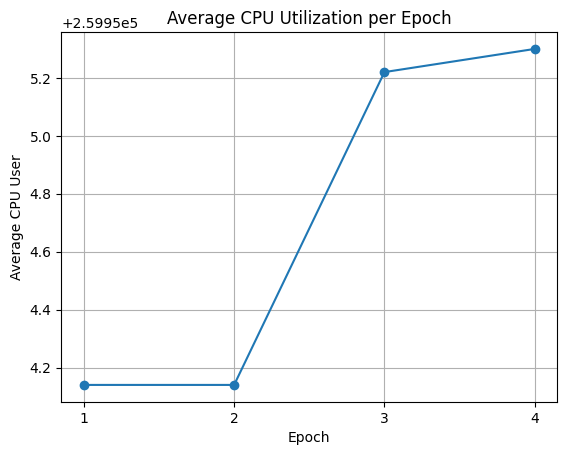

In [191]:
epochs = df.query('activity_id == "epochs_loop_iteration"')

# Compute average CPU utilization per epoch
avg_cpu = (
    epochs.groupby("used.epoch")["telemetry_at_end.cpu.times_avg.user"]
    .mean()
    .reset_index()
    .rename(columns={"used.epoch": "epoch", "telemetry_at_end.cpu.times_avg.user": "avg_cpu_util"})
)

# Plot
plt.plot(avg_cpu["epoch"], avg_cpu["avg_cpu_util"], marker="o")
plt.xticks(avg_cpu["epoch"])
plt.xlabel("Epoch")
plt.ylabel("Average CPU User")
plt.title("Average CPU per Epoch")
plt.grid(True)
plt.show()

## 4. Adding PyTorch Model Forwards

### Visualizing the Model definition as Workflow

In [206]:
_df = Flowcept.read_buffer_file(return_df=True, normalize_df=False)
row = _df.loc[df["name"].eq("TransformerModel")].iloc[0]
model_profile = row["custom_metadata"]["model_profile"]
model_profile.pop("modules")
model_repr = model_profile.pop("model_repr")
print(json.dumps(model_profile, indent=2))
print("Model Representation:")
print(model_repr)

{
  "params": 585854,
  "max_width": 600,
  "n_modules": 27
}
Model Representation:
TorchModuleWrapper(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Embedding(254, 200)
  (decoder): Linear(in_features=200, out_features=254, bias=

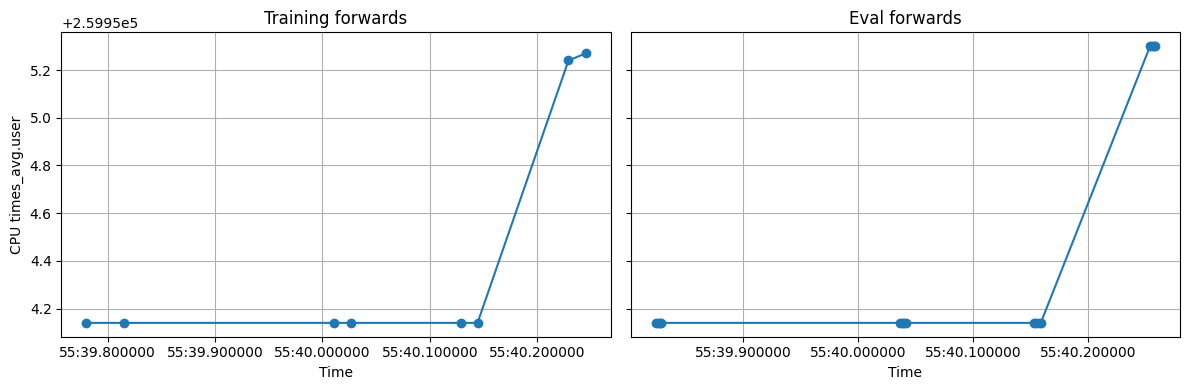

In [193]:
# Base filter: parent_forward tasks from the TransformerModel
base = df.query('activity_id == "TransformerModel" and subtype == "parent_forward"')

# Pick a time column that exists in these rows (your sample has started_at)
time_col = "started_at" if ("started_at" in df.columns and df["started_at"].notna().any()) else "ended_at"

def prep_time_series(subdf):
    s = subdf.loc[subdf["telemetry_at_end.cpu.times_avg.user"].notna(),
                  [time_col, "telemetry_at_end.cpu.times_avg.user"]].copy()
    # Convert epoch seconds to datetime for plotting
    s[time_col] = pd.to_datetime(s[time_col], unit="s", errors="coerce")
    s = s.dropna(subset=[time_col]).sort_values(time_col)
    return s

# Split by training vs evaluation based on your JSON: custom_metadata.is_training = True/False
train_fwd = prep_time_series(base.loc[base["custom_metadata.is_training"].eq(True)])
eval_fwd  = prep_time_series(base.loc[base["custom_metadata.is_training"].eq(False)])

# Plot: two subplots in a 1x2 row
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].plot(train_fwd[time_col], train_fwd["telemetry_at_end.cpu.times_avg.user"], marker="o")
axes[0].set_title("Training forwards")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("CPU times_avg.user")
axes[0].grid(True)

axes[1].plot(eval_fwd[time_col], eval_fwd["telemetry_at_end.cpu.times_avg.user"], marker="o")
axes[1].set_title("Eval forwards")
axes[1].set_xlabel("Time")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Aligning both visualizations, different granularities

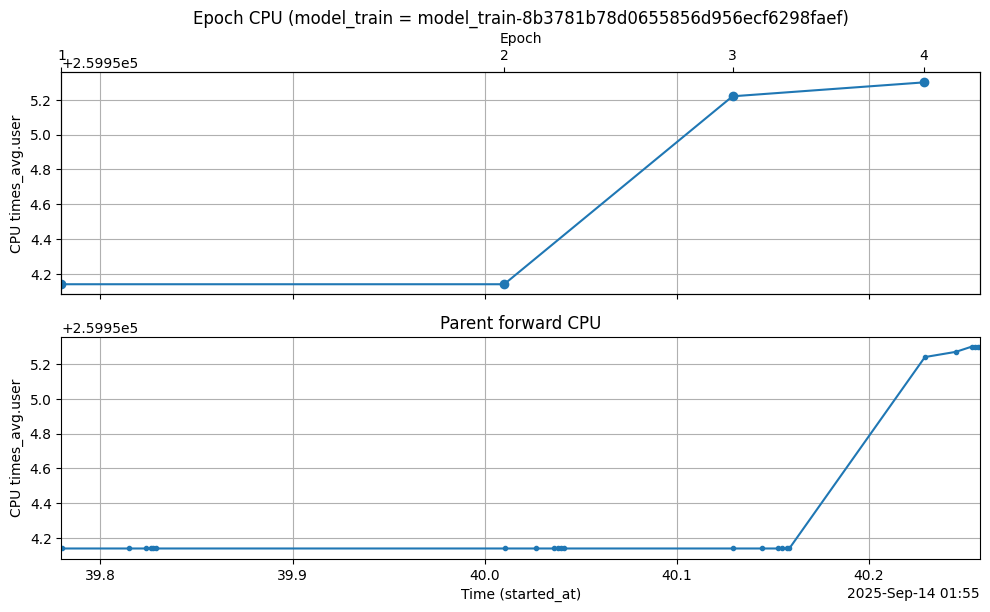

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 0) Pick one finished model_train task
mt = df.query('type == "task" and activity_id == "model_train" and status == "FINISHED"').iloc[0]
mt_id = mt["task_id"]

# --- 1) Epoch children of that model_train
epochs = df.loc[
    (df["activity_id"].eq("epochs_loop_iteration")) &
    (df["parent_task_id"].eq(mt_id))
].copy()

# --- 2) parent_forward children of those epochs
pfor = df.loc[
    (df["activity_id"].eq("TransformerModel")) &
    (df["subtype"].eq("parent_forward")) &
    (df["parent_task_id"].isin(epochs["task_id"]))
].copy()

# Choose time columns (prefer started_at if present)
tcol_pf = "started_at" if ("started_at" in pfor.columns and pfor["started_at"].notna().any()) else "ended_at"
pfor[tcol_pf] = pd.to_datetime(pfor[tcol_pf], unit="s", errors="coerce")
pfor = pfor.dropna(subset=[tcol_pf]).sort_values(tcol_pf)

# Map PF -> epoch
epoch_num_by_id = epochs.set_index("task_id")["used.epoch"].to_dict()
pfor["epoch"] = pfor["parent_task_id"].map(epoch_num_by_id)

# Build epoch-level CPU series (fallback to PF aggregation if epoch telemetry/time is missing)
has_epoch_cpu = ("telemetry_at_end.cpu.times_avg.user" in epochs.columns
                 and epochs["telemetry_at_end.cpu.times_avg.user"].notna().any())

tcol_ep = None
if "started_at" in epochs.columns and epochs["started_at"].notna().any():
    tcol_ep = "started_at"
elif "ended_at" in epochs.columns and epochs["ended_at"].notna().any():
    tcol_ep = "ended_at"

if has_epoch_cpu:
    if tcol_ep is not None:
        epochs[tcol_ep] = pd.to_datetime(epochs[tcol_ep], unit="s", errors="coerce")
        ep_series = (
            epochs.rename(columns={"used.epoch": "epoch",
                                   "telemetry_at_end.cpu.times_avg.user": "epoch_cpu"})
                  .loc[:, ["epoch", tcol_ep, "epoch_cpu"]]
                  .rename(columns={tcol_ep: "epoch_time"})
                  .dropna(subset=["epoch_time"])
                  .sort_values("epoch_time")
        )
    else:
        # No epoch time: anchor to PF median time per epoch
        ep_series = (
            epochs.rename(columns={"used.epoch": "epoch",
                                   "telemetry_at_end.cpu.times_avg.user": "epoch_cpu"})
                  .set_index("epoch")[["epoch_cpu"]]
                  .join(pfor.groupby("epoch")[tcol_pf].median().rename("epoch_time"))
                  .reset_index()
                  .dropna(subset=["epoch_time"])
                  .sort_values("epoch_time")
        )
else:
    # Aggregate from PFs: mean CPU per epoch and median time as anchor
    ep_series = (
        pfor.groupby("epoch")
            .agg(epoch_cpu=("telemetry_at_end.cpu.times_avg.user", "mean"),
                 epoch_time=(tcol_pf, "median"))
            .reset_index()
            .dropna(subset=["epoch_time"])
            .sort_values("epoch_time")
    )

# --- Plot: 2 rows x 1 column, share the x-axis (time) so gridlines align
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Common x-limits (cover both epoch times and PF times)
xmin = min(ep_series["epoch_time"].min(), pfor[tcol_pf].min())
xmax = max(ep_series["epoch_time"].max(), pfor[tcol_pf].max())
axes[0].set_xlim(xmin, xmax)

# Use the same time locator/formatter on both axes
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
for ax in axes:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, axis="both")

# Top: epoch CPU over time + secondary x-axis with epoch numbers
axes[0].plot(ep_series["epoch_time"], ep_series["epoch_cpu"], marker="o")
axes[0].set_title(f"Epoch CPU (model_train = {mt_id})")
axes[0].set_ylabel("CPU times_avg.user")

ax_top2 = axes[0].twiny()
ax_top2.set_xlim(axes[0].get_xlim())
ax_top2.set_xticks(ep_series["epoch_time"])
ax_top2.set_xticklabels(ep_series["epoch"].astype(int))
ax_top2.set_xlabel("Epoch")

# Bottom: parent_forward CPU over the *same* time axis
axes[1].plot(pfor[tcol_pf], pfor["telemetry_at_end.cpu.times_avg.user"], marker=".", linestyle="-")
axes[1].set_title("Parent forward CPU")
axes[1].set_ylabel("CPU times_avg.user")
axes[1].set_xlabel(f"Time ({tcol_pf})")

plt.tight_layout()
plt.show()
